## Imports & to run at start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os

In [2]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

## Functions

#### Plotting raw data, V vs 1/T

In [3]:
def plot_voltage_temp(dataset, title = ''):
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    fig, axs = plt.subplots(4, 2, figsize=(8, 8), dpi=200)
    fig.suptitle(title)

    for i in range(1, 8):
        ax = axs[(i-1)//2, (i-1)%2]
        ax.scatter(1/dataset['T'], dataset[f'v{i}'], s=5)
        ax.set_title(f'v{i}')

    fig.supxlabel('T (1/K)')
    fig.supylabel('Voltage (V)')
    plt.tight_layout()
    plt.show() 

#### Interpolation

In [4]:
def interp_data(dataset, new_file):
    interp_dataset = dict()
    common_time = dataset["t9"]  # using time of temperature readings

    interp_dataset['t'] = common_time

    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")
        interp_dataset[f'v{i}'] = interp_data(common_time)

    np.savez(f'interpolated_data_files/{new_file}_copy.npz', interp_dataset)
    interp_dataset['T'] = dataset['T']
    return interp_dataset

#### Plot with linear fit

In [5]:
def linear_fit(data_dict, voltage_channel):
    T = data_dict['T']
    V = data_dict[voltage_channel]

    plt.figure(figsize=(8, 4), dpi=200)
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

    # Plot the original data points
    plt.errorbar(1/T, np.log(np.abs(1/V)), xerr=0.0001, yerr=0.0000001, fmt='o', markersize=1, label=f'Voltage across {voltage_channel} connection', alpha=0.2, zorder = 1, color = 'black')
    plt.xlabel('1/T (1/K)')
    plt.ylabel('ln(1/V)')

    # Perform a linear fit on the specified section of the data
    coefficients = np.polyfit(1/T[350:], np.log(np.abs(1/V[350:])), 1)
    polynomial = np.poly1d(coefficients)

    # Generate x values for the fitted line
    T_fit = np.linspace(1/T[350], (1/T).max(), 100)
    V_fit = polynomial(T_fit)

    # Plot the fitted line on top of the original data points
    plt.plot(T_fit, V_fit, label='Linear Fit', color='red')

    plt.legend(loc='upper left')

    # plot residuals for the area of the fit
    plt.figure(figsize=(8, 4), dpi=200)
    plt.scatter(1/T[350:], np.log(np.abs(1/V[350:])) - polynomial(1/T[350:]), s=1,  label='Residuals', zorder = 1, color = 'black')
    plt.xlabel('1/T (1/K)')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
    plt.legend(loc='upper left')
    plt.show()

## Load Data

In [10]:
# No magnet or magnetic field
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)

## 1. No Heating or Magnetic field

In [ ]:
plot_voltage_temp(onemA_no_magnet, 'No heating or magnetic field, 1mA')
plot_voltage_temp(threemA_no_magnet, 'No heating or magnetic field, 3mA')
plot_voltage_temp(tenmA_no_magnet, 'No heating or magnetic field, 10mA')
plot_voltage_temp(thirtymA_no_magnet, 'No heating or magnetic field, 30mA') 

## Interim Report Plots

### Raw measurement plot

In [6]:
# loading one of the heated, magnetic field datasets we took on the 12th
data_run = '350mV_10mA_heating'
data_path = user_path+f'/PHYS469/hall_experiment/09122024/{data_run}.csv'
data_csv = pd.read_csv(data_path, header=2)
data_dict = interp_data(data_csv, data_run)

fitting the linear part of the data

$$ \sigma = \frac{IL}{VA} = \sigma_o \exp(\frac{-Eg}{2kT})$$

so if we plot ln(1/V) vs 1/T, we should get a straight line

In [ ]:
# are we using hall voltage or voltage along the current...? 

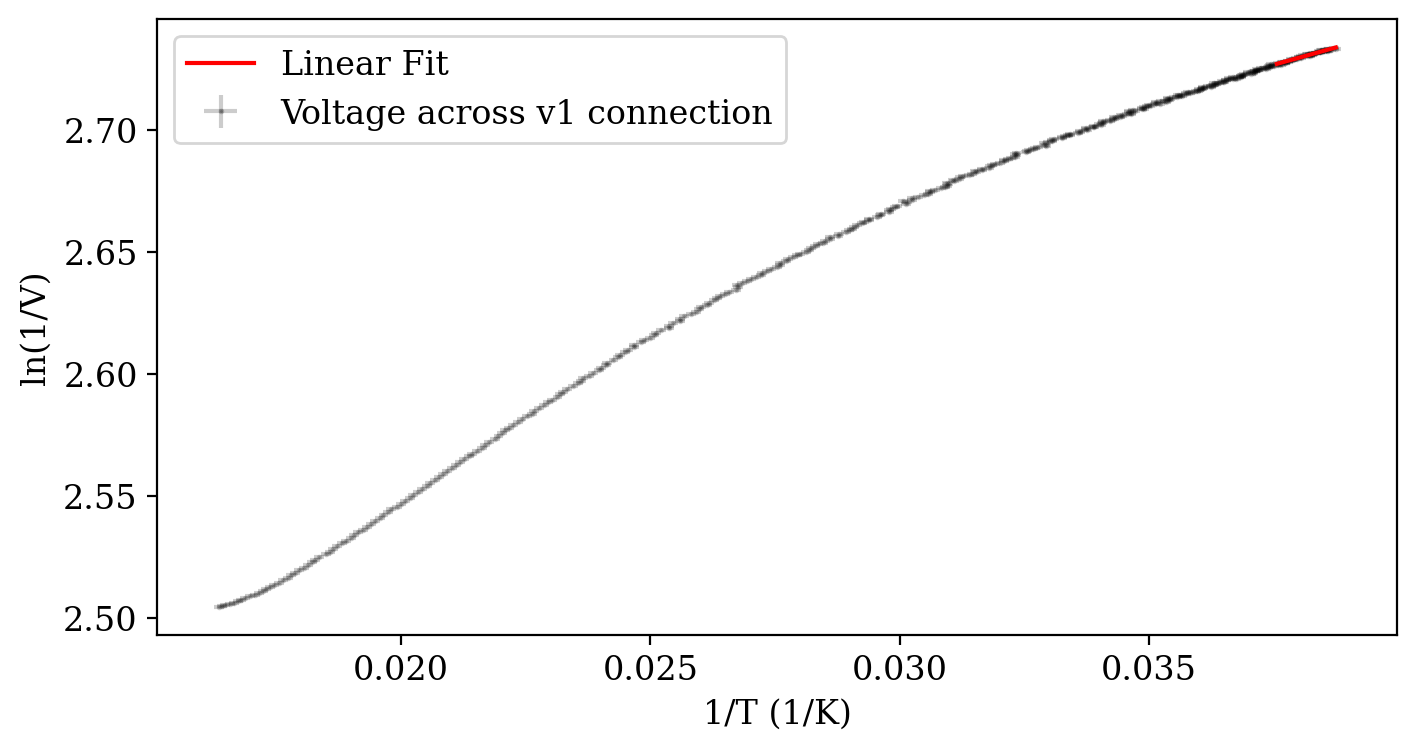

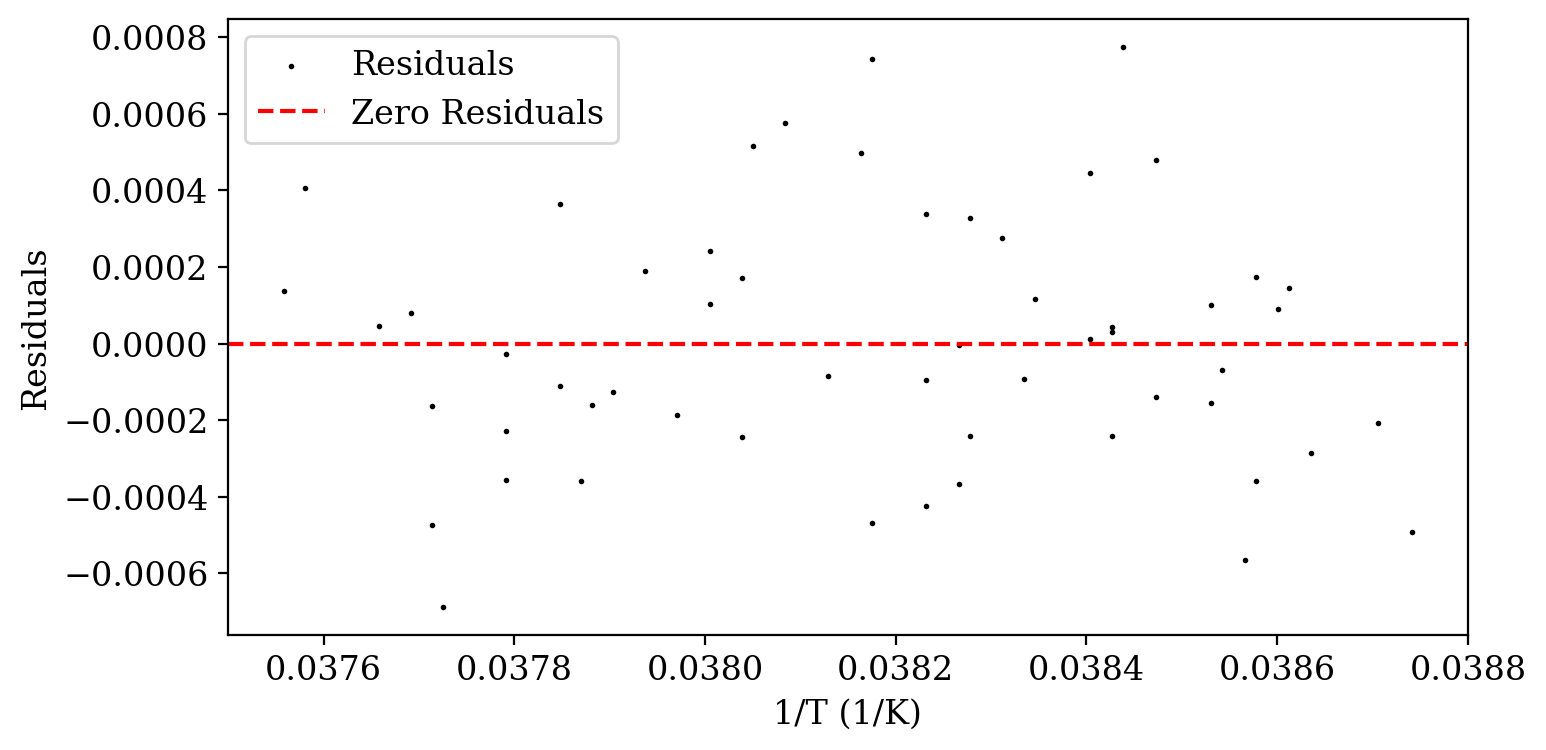

In [8]:
linear_fit(data_dict, 'v1')

[-0.7504728  -0.75087487 -0.7512326  -0.7515524  -0.75183017 -0.75207544
 -0.75228304 -0.75245174 -0.75259134 -0.75270003 -0.75277448 -0.75282171
 -0.7528442  -0.75283567 -0.75279593 -0.75272838 -0.75263359 -0.7525132
 -0.75237224 -0.75220494 -0.75201179 -0.75179348 -0.75156222 -0.75131031
 -0.75104096 -0.75076518 -0.75046941 -0.75015401 -0.74982827 -0.74948903
 -0.74913595 -0.74877269 -0.74840436 -0.74801817 -0.74762878 -0.74722111
 -0.74680723 -0.74638529 -0.74594661 -0.74550776 -0.74506013 -0.74459689
 -0.74411867 -0.74364162 -0.74315111 -0.74266476 -0.74216767 -0.74166593
 -0.74115846 -0.74063672 -0.74011022 -0.73958329 -0.73905794 -0.73852061
 -0.73798513 -0.73744715 -0.73690966 -0.73637359 -0.73582192 -0.73527824
 -0.73472623 -0.73417058 -0.73360983 -0.73305835 -0.73250147 -0.73194058
 -0.73137036 -0.73080391 -0.73023351 -0.72966241 -0.7290972  -0.72853225
 -0.72797834 -0.72742078 -0.72686586 -0.72631323 -0.72574167 -0.7251717
 -0.72460315 -0.7240342  -0.7234616  -0.72289671 -0.7

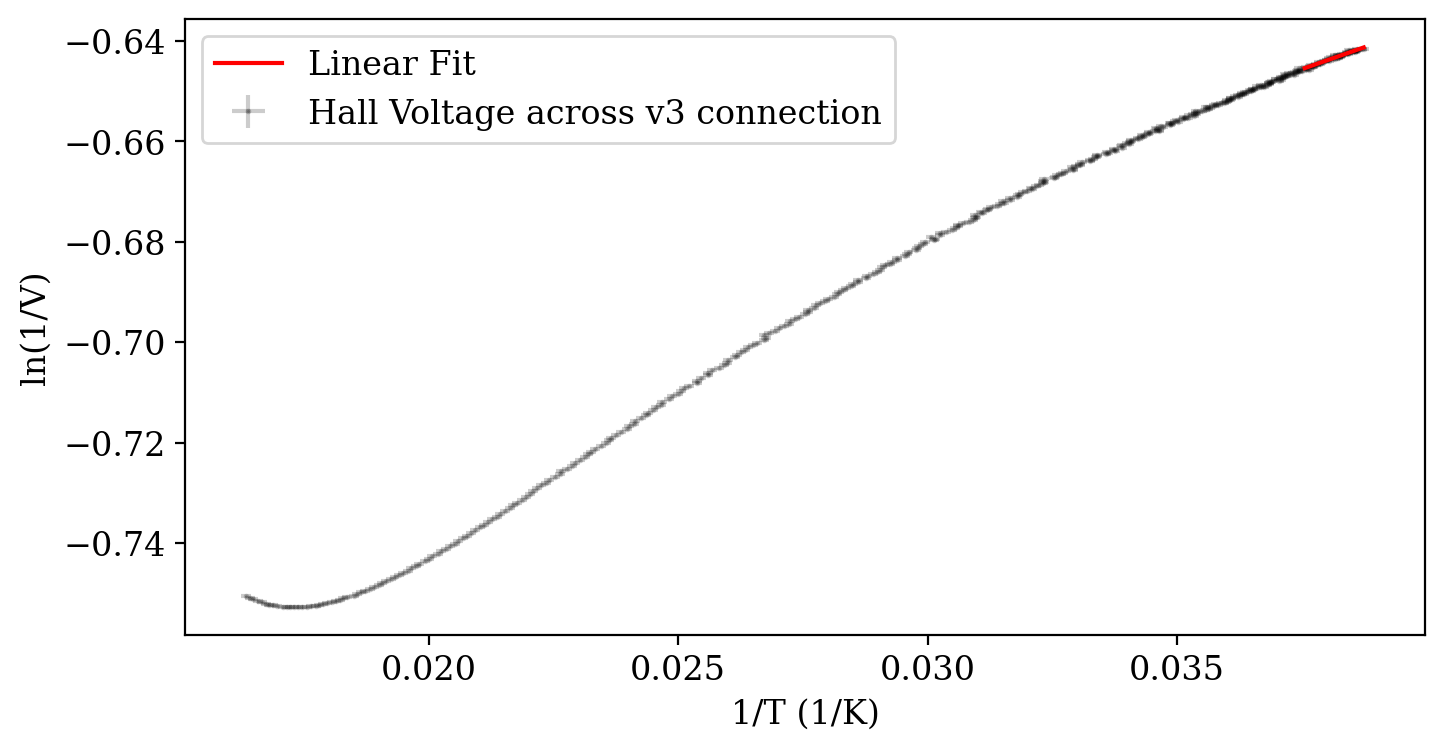

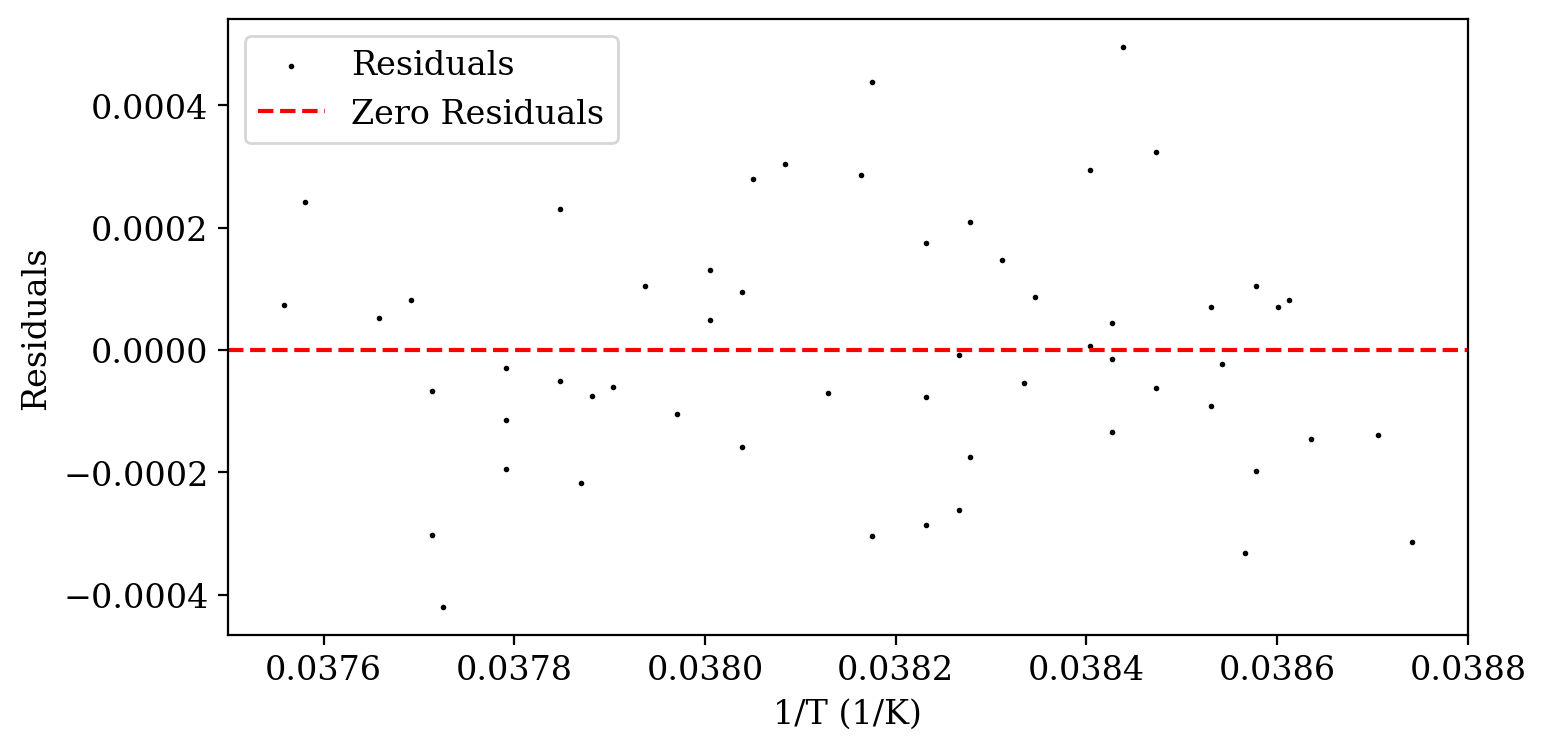

In [12]:
linear_fit(data_dict, 'v3')

# FOR AUDREY;
# I think the uncertainty on the Thermocouple is 0.0001, and 0.0000001 on V1

In [ ]:
plot_voltage_temp(data_dict)

<!--  -->

TO DO: 
- calculate the base conductivity
- calculate the band gap energy